## Prediction of heart failure with ANN

Data from Kaggle: https://www.kaggle.com/code/surajjha101/heart-failure-prediction-svm-and-ann/notebook#list-tab

In [1]:

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns



In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from IPython import display

2023-06-16 22:08:13.627396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the dataset

In [3]:
## loading train dataset 
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Descriptive Analysis

In [ ]:
df.info()
## there are 299 records and 13 columns ( 12 features + 1 target variable: DEATH_EVENT)
## 6 encoded categorical variables and remaining 6 numeric variables
## 3 float columns and 9 integer columns 


In [ ]:
#Description about the dataset's characteristics
display.Image('description_attributes.png',width = 400)

In [ ]:
## statistics of variables
df.describe()

In [ ]:
## explore unique values for each column
column_names = list(df.columns)
for col in column_names:
    print(col, ':', df[col].nunique(), )

In [4]:
## separating the column names into numerical and categorical
num_col = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium', 'time']
cat_col = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']

## to get subset of df 
#df.loc[:,['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']]

## Cleaning the dataset

In [ ]:
## checking misssing values: no missing values
df.isnull().sum()

In [ ]:
## inital pairplot visualisation to see overall dsitribution or relationship
sns.set_theme(style="ticks")
sns.pairplot(df.loc[:,num_col])

## int the diagonal we can see that the variables seems to follow the normal distribution but are very skewed due to outliers. So we will convert outliers
## to the median. We cannot remove the records as there are only 299 records. 

In [5]:
## convert all outliers into the median as the mean is affected by the outliers

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    UB = Q3 + 1.5* IQR #1280.25 upper bound for outliers
    LB = Q1 - 1.5* IQR #lowe upper bound for outliers
    df[col] = np.where(df[col] > UB, int(df[col].mean()),df[col])
    df[col] = np.where(df[col] < LB, int(df[col].mean()),df[col])
    

#to get the outliers in df format
#print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))

df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,581,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,1.0,136,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,581,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,581,1,60,0,263358.00,0.8,138,0,0,278,0
297,45.0,0,581,0,38,0,140000.00,1.4,140,1,1,280,0


In [ ]:
## check whether we should convert the float column 'age' into an integer as the values seems to be all ending in .00
age_df = df['age']
count_0_age = 0
count_not0_age= 0
for a in age_df:
    if a%1==0:
        count_0_age += 1
    else:
        count_not0_age += 1
        print(a)
print(f'Number of values ending with .00 is {count_0_age}.')
print(f'Number of values not ending with .00 is {count_not0_age}.')
#there is only 2 values not ending with .00 so we can convert it to an integer type

In [ ]:
## check whether we should convert the float column 'platelets' into an integer as the values seems to be all ending in .00
plat_df = df['platelets']
count_0_plat = 0
count_not0_plat= 0
for a in plat_df:
    if a%1==0:
        count_0_plat += 1
    else:
        count_not0_plat += 1
        #print(a)
print(f'Number of values ending with .00 is {count_0_plat}.')
print(f'Number of values not ending with .00 is {count_not0_plat}.')
#there is only 2 values not ending with .00 so we can convert it to an integer type

In [6]:
## convert 'age' and 'platelets' to an integer type
df['age'] = df['age'].astype(int)
df['platelets'] = df['platelets'].astype(int)


In [7]:
## the clean to be analysed and worked on

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,581,0,38,0,263358,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000,1.0,136,0,0,8,1


## Data Analysis 

<function matplotlib.pyplot.show(close=None, block=None)>

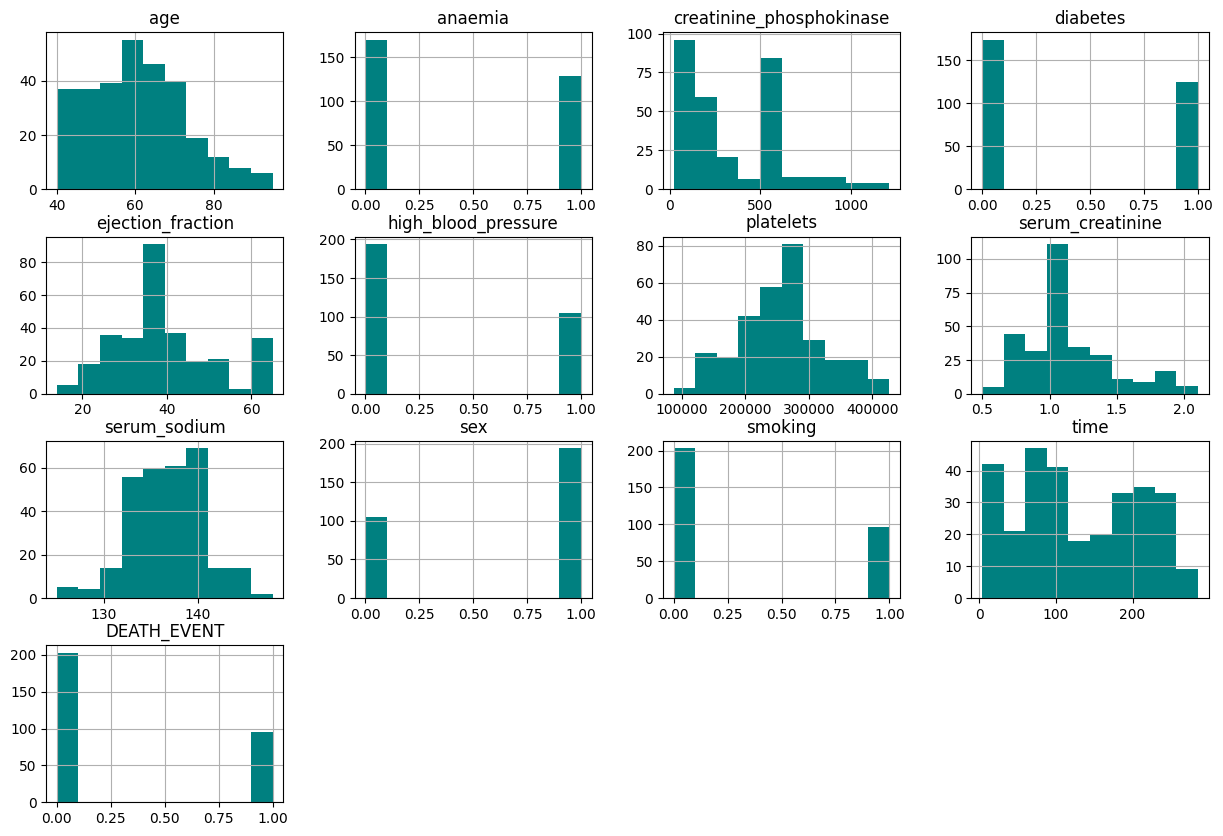

In [50]:
## histogram of each variables
df.hist(bins=10, figsize=(15,10), color='teal')
plt.show

Numerical variables

In [ ]:
## scatterplot for each pair of the numerical columns after converting the outliers
## we can see better the normal distribution
sns.set_theme(style="ticks")
sns.pairplot(df.loc[:,num_col])

In [ ]:
## explore general distribution of data after outliers converted to median
plt.figure(figsize=(100,100))
df.plot(kind='box')
plt.xticks( rotation = 90)
#plateles's data scale is extremley different others, therefore stnadardisation will be needed

In [ ]:
## explore distribution of each characteristic using boxplots after outliers converted to median
#numerical data in num_df
for column in num_col:
    plt.figure(figsize=(10,2))
    #df.boxplot([column])
    sns.boxplot(data=df, x=column)

/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_47551/1849219715.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df['time'][df.DEATH_EVENT == 0], color= 'blue', shade=True)
/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_47551/1849219715.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['time'][df.DEATH_EVENT == 1], color='red', shade=True)


<function matplotlib.pyplot.show(close=None, block=None)>

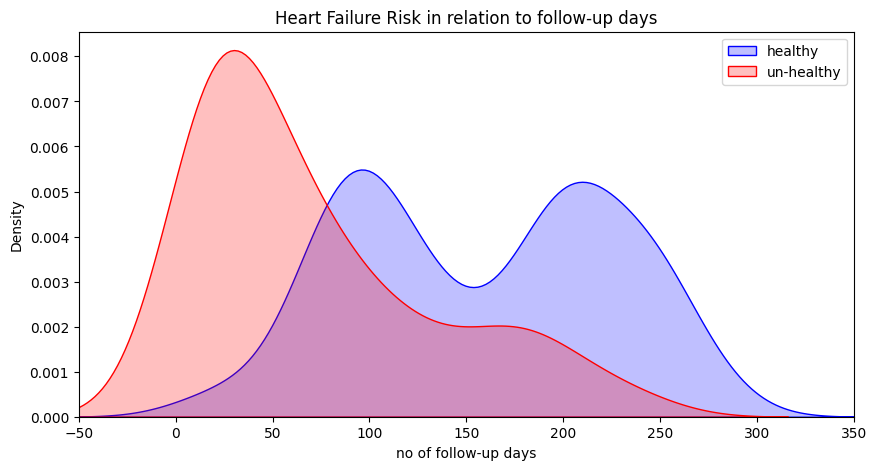

In [44]:
## distribution and relation of time and death_event
plt.figure(figsize=(10,5))

ax = sns.kdeplot(df['time'][df.DEATH_EVENT == 0], color= 'blue', shade=True)
sns.kdeplot(df['time'][df.DEATH_EVENT == 1], color='red', shade=True)

plt.legend(['healthy', 'un-healthy'])
plt.title('Heart Failure Risk in relation to follow-up days')
ax.set(xlabel='no of follow-up days')
plt.xlim(-50, 350)
plt.show

/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_47551/3460007820.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df['ejection_fraction'][df.DEATH_EVENT == 0], color= 'blue', shade=True)
/var/folders/j8/vzdf09mx34vcvn_f8vhtx07w0000gn/T/ipykernel_47551/3460007820.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['ejection_fraction'][df.DEATH_EVENT == 1], color='red', shade=True)


<function matplotlib.pyplot.show(close=None, block=None)>

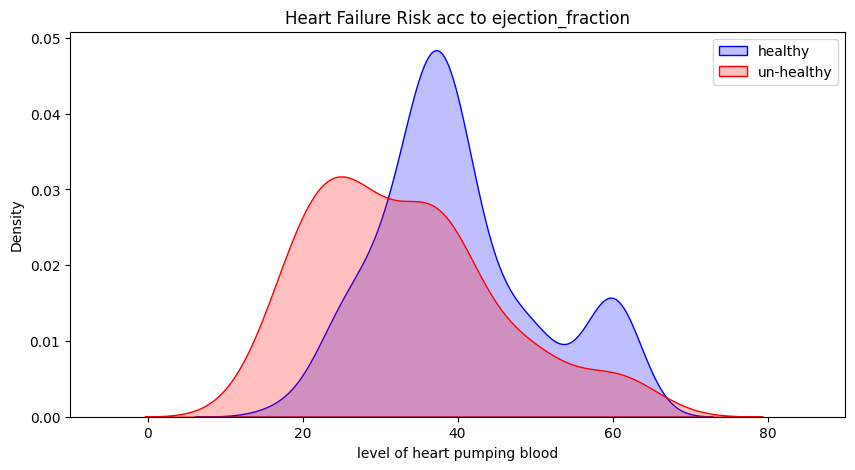

In [45]:
## distribution and relationship between ejaction_fraction and death_event
plt.figure(figsize=(10,5))

ax = sns.kdeplot(df['ejection_fraction'][df.DEATH_EVENT == 0], color= 'blue', shade=True)
sns.kdeplot(df['ejection_fraction'][df.DEATH_EVENT == 1], color='red', shade=True)

plt.legend(['healthy', 'un-healthy'])
plt.title('Heart Failure Risk acc to ejection_fraction')
ax.set(xlabel='level of heart pumping blood')
plt.xlim(-10, 90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

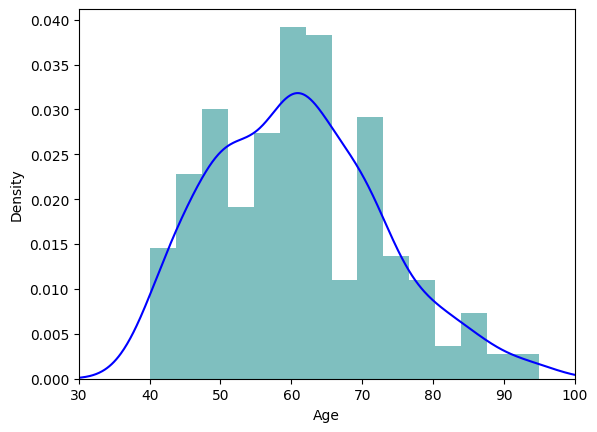

In [46]:
## plot histogram to of age distribution
Age_histogram = df['age'].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.5)
df['age'].plot(kind='density', color= 'blue')
Age_histogram.set(xlabel= 'Age')
plt.xlim(30, 100)
plt.show

Categorical variables

In [ ]:
## count of people dead from heart failure 
death_count = df.groupby(['DEATH_EVENT']).size().reset_index(name="Count")
death_count['Percentage'] = round(death_count['Count'] *100/ len(df),2)
death_count

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = "DEATH_EVENT", y = 'Percentage',data=death_count )
ax.set_title('Percentage of death from heart failure')
ax.set( xlabel= None , ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels(['not dead', 'dead'])

## suggests that there's an imbalance of dataset so the model might be better in predicting the outcome for people who didn't die

In [ ]:
## subsetting the df with only categorical variables 
cat_col_df = df.loc[:,['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']]

## rename the column names to be used to create barplots in the loop below
cat_col_df.rename(columns={'anaemia': 'anaemic', 'diabetes': 'diabetic','high_blood_pressure': 'high blood pressure', 'sex': 'male','smoking': 'smoker', 'DEATH_EVENT': 'DEATH_EVENT'}, inplace=True)
cat_col_df

## loop to creat a barplot for each feature 
for col in cat_col_df[:-1]:   
    death_count = cat_col_df.groupby(['DEATH_EVENT',col]).size().reset_index(name="Count")
    death_count['Percentage'] = round(death_count['Count'] *100/ len(df),2)
    death_count

    plt.figure(figsize=(5,5))
    sns.set(style="darkgrid")
    ax = sns.barplot(x = col , y = 'Percentage',data=death_count, hue="DEATH_EVENT" )
    ax.set_title(f'Heart failure death due to feature: {col}')
    ax.set( xlabel= None , ylabel= None)
    vals = ax.get_yticks()
    ax.set_yticklabels([f'{x:g}%' for x in vals])
    ax.set_xticklabels([f"non-{col}", f"{col}"])
    ax.set_ylim([0, 50])

    handles, labels = ax.get_legend_handles_labels()
    labels = ['not dead', 'dead']
    ax.legend(handles, labels)

In [ ]:
## recreate the graph for sex so the legend makes sense (women, men instead of non-male and male)
death_count_sex = df.groupby(['DEATH_EVENT', 'sex']).size().reset_index(name="Count")
death_count_sex['Percentage'] = round(death_count_sex['Count'] *100/ len(df),2)
death_count_sex

plt.figure(figsize=(5,5))
sns.set(style="darkgrid")
ax = sns.barplot(x = "sex", y = 'Percentage',data=death_count_sex , hue='DEATH_EVENT')
ax.set_title('Percentage of death by gender from heart failure')
ax.set( xlabel= None , ylabel= None)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:g}%' for x in vals])
ax.set_xticklabels(["women", "men"])
ax.set_ylim([0, 50])


handles, labels = ax.get_legend_handles_labels()
labels = ['Not dead', 'Dead']
ax.legend(handles, labels)


## Correlation Matrix
To check the relationship between independent variables and target variable 'DEATH_EVENT'

Highest correlated variables:\
-time: -0.53\
-serum_creatinine: 0.29\
-ejection_fraction: -0.27\
-age: 0.25\
-serum_sodium: -0.2\
others below 0.1

In [ ]:
## check for correlation
corr_mat = df.corr()
corr_mat

## show correlation using heatmap
plt.figure(figsize=(16,16))
heat = sns.heatmap(corr_mat,annot=True) 
#heat.set_xticklabels(heat.get_xticklabels(), rotation=45)


## Splitting data into training and testing

In [8]:
## select dep and indep 
X = df.iloc[:,:-1].values 
y = df.iloc[:,-1].values

# spplit into train test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=32) 

In [9]:
## standardisation
# input data is transformed to have a mean of zero and a std of 1 
scaler_x = StandardScaler() #create object 
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test) 

## Model 1 

In [ ]:
## initialise the simple neural network
model = Sequential() 

## input layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation =  'relu', input_dim = 12)) 

## hidden layer
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation =  'relu'))

## regularisation -- help to stop overfitting
model.add(Dropout(0.25)) #0.25 = 25% random will be set to 0 during training

## output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation =  'sigmoid')) 

## compiling the ANN
model.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy']) 

In [ ]:
## summary: information about shape, type and parameters of network
model.summary()

In [40]:
## train our network
## 20% for testing, 25% for validation and 55% for training
history = model.fit(X_train, y_train, batch_size = 32, epochs = 80, validation_split =0.25 )

#0.5 without simple change
#0.6 with replacing outliers with median values
#0.8 with standardisation: loss: 0.4002 - accuracy: 0.8883 - val_loss: 0.4244 - val_accuracy: 0.8333
# another replace same code : loss: 0.3968 - accuracy: 0.8603 - val_loss: 0.4326 - val_accuracy: 0.8333 - worse 
# with median  loss: 0.3215 - accuracy: 0.9106 - val_loss: 0.4741 - val_accuracy: 0.8333

Epoch 1/80
6/6 [==============================] - 1s 47ms/step - loss: 0.3673 - accuracy: 0.8436 - val_loss: 0.3687 - val_accuracy: 0.8333
Epoch 2/80
6/6 [==============================] - 0s 13ms/step - loss: 0.3567 - accuracy: 0.8324 - val_loss: 0.3697 - val_accuracy: 0.8333
Epoch 3/80
6/6 [==============================] - 0s 14ms/step - loss: 0.3551 - accuracy: 0.8547 - val_loss: 0.3692 - val_accuracy: 0.8333
Epoch 4/80
6/6 [==============================] - 0s 14ms/step - loss: 0.3392 - accuracy: 0.8659 - val_loss: 0.3699 - val_accuracy: 0.8333
Epoch 5/80
6/6 [==============================] - 0s 13ms/step - loss: 0.3485 - accuracy: 0.8603 - val_loss: 0.3714 - val_accuracy: 0.8500
Epoch 6/80
6/6 [==============================] - 0s 16ms/step - loss: 0.3710 - accuracy: 0.8380 - val_loss: 0.3723 - val_accuracy: 0.8500
Epoch 7/80
6/6 [==============================] - 0s 15ms/step - loss: 0.3446 - accuracy: 0.8492 - val_loss: 0.3726 - val_accuracy: 0.8500
Epoch 8/80
6/6 [===========

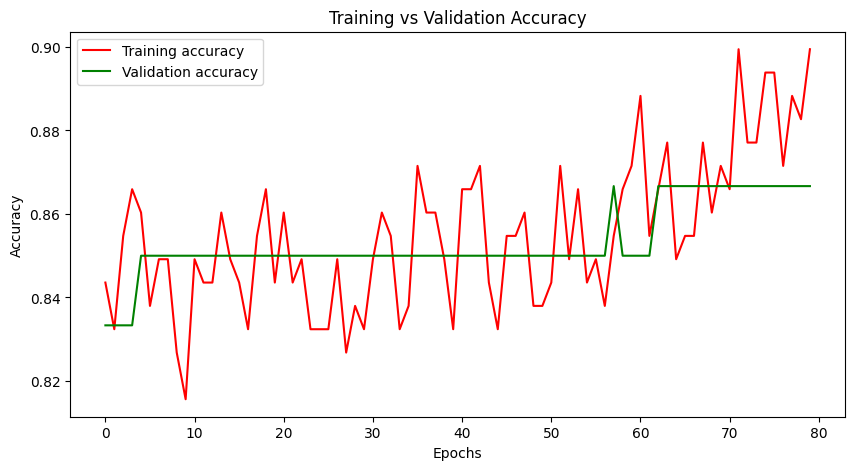

In [41]:
## does validation and training accuracy increase over time?


history_df= pd.DataFrame(history.history)

plt.figure(figsize=(10,5))
plt.plot(history_df.loc[:, ['accuracy']], color= 'red', label= 'Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], color= 'green', label= 'Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

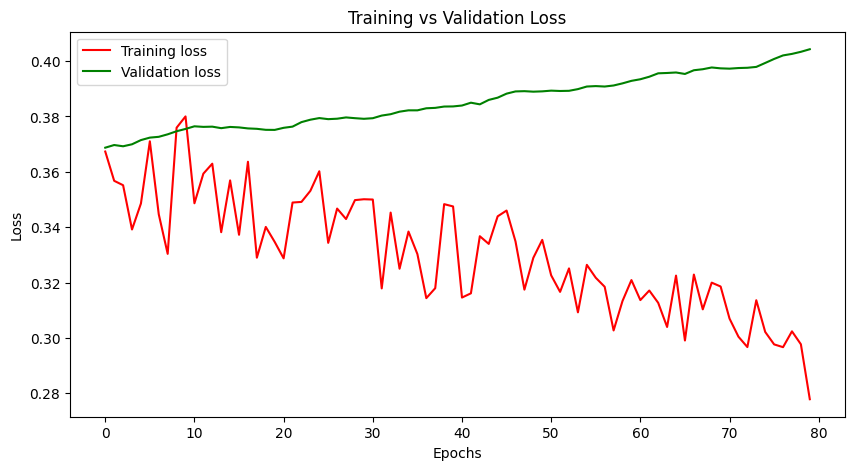

In [42]:
## does validation and training loss decrease over time?

plt.figure(figsize=(10,5))
plt.plot(history_df.loc[:, ['loss']], color= 'red', label= 'Training loss')
plt.plot(history_df.loc[:, ['val_loss']], color= 'green', label= 'Validation loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
## save our model
#model.save('ann_model1')

#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=32) 

## initialise the simple neural network
#model = Sequential() 

## input layers
#model.add(Dense(units = 16, kernel_initializer = 'uniform', activation =  'relu', input_dim = 12)) 

## hidden layer
#model.add(Dense(units = 8, kernel_initializer = 'uniform', activation =  'relu'))

## regularisation -- help to stop overfitting
#model.add(Dropout(0.25)) #0.25 = 25% random will be set to 0 during training

## output layer
#model.add(Dense(units = 1, kernel_initializer = 'uniform', activation =  'sigmoid')) 

## compiling the ANN
#model.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy']) 

## 20% for testing, 25% for validation and 55% for training
#history = model.fit(X_train, y_train, batch_size = 32, epochs = 80, validation_split =0.25 )


#loss: 0.3402 - accuracy: 0.8436 - val_loss: 0.3690 - val_accuracy: 0.8500

In [39]:
##load, saved model
model = tf.keras.models.load_model('ann_model1')

In [ ]:
## predict X_test with model1
y_pred = model.predict(X_test)
y_pred

In [ ]:
## cap value
y_pred = np.where(y_pred > 0.5, 1, 0) #anything above 0.5 make it 1, else 0
y_pred

In [ ]:
## classification report
print(classification_report(y_test, y_pred)) #needs binary

In [ ]:
#confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat = conf_mat , figsize = (4,4), cmap = 'Greens')
plt.xlabel('Predictions', fontsize = 12 )
plt.xlabel('Actuals', fontsize = 12 )
plt.title('Confusion Matrix of Model 1', fontsize = 12 )
plt.show()

In [ ]:
## CALCULATE AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %f' %auc)


fpr, tpr = roc_curve(y_test, y_pred)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Model 1')
plt.text(y= 0.6, x=0.2, s=f'score: {round(auc,6)}')
plt.legend()
plt.show()

## Model 2 

Added another 2nd hidden layer at units 4 

Model 1: loss: 0.3402 - accuracy: 0.8436 - val_loss: 0.3690 - val_accuracy: 0.8500
Model 2: loss: 0.4240 - accuracy: 0.8492 - val_loss: 0.4184 - val_accuracy: 0.8667

In [ ]:
## initialise the simple neural network
model2 = Sequential() 

## input layers
model2.add(Dense(units = 16, kernel_initializer = 'uniform', activation =  'relu', input_dim = 12)) 

## hidden layer
model2.add(Dense(units = 8, kernel_initializer = 'uniform', activation =  'relu'))

####### adding another layer
model2.add(Dense(units = 4, kernel_initializer = 'uniform', activation =  'relu'))

## regularisation -- help to stop overfitting
model2.add(Dropout(0.25)) #0.25 = 25% random will be set to 0 during training

## output layer
model2.add(Dense(units = 1, kernel_initializer = 'uniform', activation =  'sigmoid')) 

## compiling the ANN
model2.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy']) 

## summary: information about shape, type and parameters of network
model2.summary()

## train our network
## 20% for testing, 25% for validation and 55% for training
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 80, validation_split =0.25 )

In [ ]:
## save our model
#model2.save('ann_model2')


In [ ]:
## load our saved data
model2 = tf.keras.models.load_model('ann_model2')

In [ ]:
## predict X_test with model
y_pred2 = model2.predict(X_test)
## cap value
y_pred2 = np.where(y_pred2 > 0.5, 1, 0) #anything above 0.5 make it 1, else 0
y_pred2

## classification report
print(classification_report(y_test, y_pred2)) 

In [ ]:
#confusion matrix
conf_mat2 = confusion_matrix(y_test, y_pred2)
fig, ax = plot_confusion_matrix(conf_mat = conf_mat2 , figsize = (4,4), cmap = 'Greens')
plt.xlabel('Predictions', fontsize = 12 )
plt.xlabel('Actuals', fontsize = 12 )
plt.title('Confusion Matrix of Model 2', fontsize = 12 )
plt.show()

In [ ]:
## CALCULATE AUC
auc2 = roc_auc_score(y_test, y_pred2)
print('AUC: %f' %auc2)


fpr, tpr = roc_curve(y_test, y_pred2)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Model 2')
plt.text(y= 0.6, x=0.2, s=f'score: {round(auc2,6)}')
plt.legend()
plt.show()

## Model 3 

From model 2: changed Dropout from 0.25 to 0.15


Model 1: loss: 0.3402 - accuracy: 0.8436 - val_loss: 0.3690 - val_accuracy: 0.8500
Model 2: loss: 0.4240 - accuracy: 0.8492 - val_loss: 0.4184 - val_accuracy: 0.8667
Model 3: loss: 0.4021 - accuracy: 0.8715 - val_loss: 0.4017 - val_accuracy: 0.8667

In [ ]:
## initialise the simple neural network
model3 = Sequential() 

## input layers
model3.add(Dense(units = 16, kernel_initializer = 'uniform', activation =  'relu', input_dim = 12)) 

## hidden layer
model3.add(Dense(units = 8, kernel_initializer = 'uniform', activation =  'relu'))

####### adding another layer
model3.add(Dense(units = 4, kernel_initializer = 'uniform', activation =  'relu'))

##### drop out to 15% insteadof 25% (regularisation -- help to stop overfitting)
model3.add(Dropout(0.15)) #0.25 = 25% random will be set to 0 during training

## output layer
model3.add(Dense(units = 1, kernel_initializer = 'uniform', activation =  'sigmoid')) 

## compiling the ANN
model3.compile(optimizer = 'adam', loss =  'binary_crossentropy', metrics=['accuracy']) 

## summary: information about shape, type and parameters of network
model3.summary()

## train our network
## 20% for testing, 25% for validation and 55% for training
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 80 , validation_split =0.25 )

In [ ]:
## save our model
#model3.save('ann_model3')

## load our saved data
model3 = tf.keras.models.load_model('ann_model3')

## predict X_test with model
y_pred3 = model3.predict(X_test)
## cap value
y_pred3 = np.where(y_pred3 > 0.5, 1, 0) #anything above 0.5 make it 1, else 0
#y_pred3

## classification report
print(classification_report(y_test, y_pred3)) 

In [ ]:
#confusion matrix
conf_mat3 = confusion_matrix(y_test, y_pred3)
fig, ax = plot_confusion_matrix(conf_mat = conf_mat3 , figsize = (4,4), cmap = 'Greens')
plt.xlabel('Predictions', fontsize = 12 )
plt.xlabel('Actuals', fontsize = 12 )
plt.title('Confusion Matrix of Model 3', fontsize = 12 )
plt.show()

In [ ]:
## CALCULATE AUC
auc3 = roc_auc_score(y_test, y_pred3)
print('AUC: %f' %auc3)


fpr, tpr = roc_curve(y_test, y_pred3)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Model 3')
plt.text(y= 0.6, x=0.2, s=f'score: {round(auc3,6)}')
plt.legend()
plt.show()

## Conclusion

The best model I have found is model 3: with 2 hidden layers and a regularisation layer with a dropout of 15%.


Results from models:

Model 1: loss: 0.3402 - accuracy: 0.8436 - val_loss: 0.3690 - val_accuracy: 0.8500
Model 2: loss: 0.4240 - accuracy: 0.8492 - val_loss: 0.4184 - val_accuracy: 0.8667
Model 3: loss: 0.4021 - accuracy: 0.8715 - val_loss: 0.4017 - val_accuracy: 0.8667


The confusion matrices of the 3 models predicted the True Negatives the most and this could be due to the imbalance of data having more data
about people who didn't die from heart attack. 


Next step: 
-remove all outliers from platelets that still lingered
-remove some data about the people who didn't die so more balanced data.
-experiment with hyperparatuning the models